In [ ]:
!pip install transformers
!pip install datasets 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 31.3 MB/s eta 0:00:0

In [ ]:
import torch
import datasets
import numpy as np
import pandas as pd
from datasets import load_dataset
from datasets import DatasetDict
from transformers import GPT2LMHeadModel, GPT2TokenizerFast,AutoConfig
import torch
import torch.nn as nn
from transformers.optimization import Adafactor
import transformers
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

Loading Xsum-dataset

In [ ]:
raw_datasets = load_dataset("xsum")
train_data = raw_datasets['train']
test_data = raw_datasets['test']

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
raw_datasets = DatasetDict(
    {
        "train": train_data.select(range(500)),
        "test": test_data.select(range(500)),
    }
)

Loading GPT-2 model

In [ ]:
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained('gpt2').to("cuda")

In [ ]:
tokenizer.add_special_tokens({'pad_token':'[PAD]'})
PAD_IDX = tokenizer.pad_token_id
PAD_IDX

50257

In [ ]:
config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=512,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)
model = GPT2LMHeadModel(config).to("cuda")

Preprocessing xsum dataset and obtaining the final input_ids,attention_mask and label

In [ ]:
prefix_len = 20
def preprocess_function(examples, prefix_len=20, padding=True):
    text_column = 'document'
    summary_column = 'summary'
    keyword_column = 'Keywords'

    max_source_length = 512  
    max_target_length = 512

    text = examples[text_column]
    targets = examples[summary_column]
    keyword = examples[keyword_column]

    inputs = " ".join(text.split(' '))[:300]  #for each sample we are only taking 200 words
    inputs = '<|endoftext|>' + inputs + 'TL;DR:' + targets + '<|endoftext|>'
    #tokenize inputs, label and important sentences
    model_inputs = tokenizer(inputs, return_tensors="pt", padding=padding, max_length=max_source_length, truncation=True)
    labels = tokenizer(targets, padding=padding, max_length=max_target_length, return_tensors="pt", truncation=True)
    importance_keywords = tokenizer(keyword, padding="max_length", max_length=prefix_len, return_tensors="pt", truncation=True)
    input_length = model_inputs['input_ids'].shape[1]
    target_length = labels["input_ids"].shape[1]
   
    #print(max_source_length,target_length,prefix_len,input_length)
    #concat input ids with importance sentences in the front and label in the back
    model_inputs['input_ids'] = torch.cat([importance_keywords['input_ids'],model_inputs['input_ids'],torch.full((1,max_source_length-prefix_len-input_length), PAD_IDX)],1)
    #print('Input shape',model_inputs['input_ids'].shape)
    #concat label with -100 in the front and padding
    labels["input_ids"] = torch.cat([torch.full((1,prefix_len),-100), labels['input_ids'],torch.full((1,max_target_length-prefix_len-target_length), PAD_IDX)],1)
    model_inputs["labels"] = labels["input_ids"]
    #print(labels['input_ids'].shape)
    #concat attention with 0 in the back
    attention_length = model_inputs["attention_mask"].shape[1]
    model_inputs["attention_mask"] = torch.cat([importance_keywords['attention_mask'],model_inputs["attention_mask"],torch.full((1,max_source_length-prefix_len-attention_length), 1)],1)

    return model_inputs

obtaining top-20-keywords

In [ ]:
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

In [ ]:
import spacy

# Load the spaCy model

nlp = spacy.load("en_core_web_sm")
# Define a function to extract the top 5 keywords from a text
# Define a function to extract the top 5 keywords from a text
def extract_keywords(text,nlp):
    doc = nlp(text)
    # Get the noun chunks and their frequencies
    noun_chunks = {}
    for chunk in doc.noun_chunks:
        chunk_text = " ".join([token.text for token in chunk if token.text.lower() != "the"])
        if chunk_text.lower() not in nlp.Defaults.stop_words:
            if chunk_text not in noun_chunks:
                noun_chunks[chunk_text] = 1
            else:
                noun_chunks[chunk_text] += 1
    # Sort the noun chunks by frequency and return the top 5
    sorted_chunks = sorted(noun_chunks.items(), key=lambda x: x[1], reverse=True)
    return ', '.join([chunk[0] for chunk in sorted_chunks[:20]])

def keywords(example,nlp):
  # Loop through each sample in the train data and extract the top 5 keywords
    text = example["document"]
    keywords = extract_keywords(text,nlp)
  
    return {"Keywords":keywords}


In [ ]:
nlp = spacy.load("en_core_web_sm")
raw_datasets =  raw_datasets.map(lambda example:keywords(example,nlp))

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
raw_datasets["train"]['Keywords'][0]

'damage, Newton Stewart, areas, Hawick, flooding, area, Dumfries, place, Borders, calls, situation, full cost, Repair work, many roads, Peeblesshire, standing water, Trains, west coast mainline, disruption, Lamington Viaduct'

In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
column_names = ['document', 'summary', 'id', 'Keywords']
new_train_dataset = raw_datasets["train"].map(lambda example : preprocess_function(example,prefix_len),remove_columns=column_names)
new_test_dataset = raw_datasets["test"].map(lambda example : preprocess_function(example,prefix_len),remove_columns=['summary', 'id', 'Keywords'])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
#new_test_dataset = raw_datasets["test"].map(lambda example : preprocess_function(example,prefix_len),remove_columns=['summary', 'id', 'Keywords'])

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
BATCH_SIZE = 8
new_train_dataset.set_format("torch")
loader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE)

In [ ]:
for batch in loader:
    input=batch["input_ids"].to("cuda:0")
    attention = batch["attention_mask"].to("cuda:0")
    label = batch["labels"].to("cuda:0")
    print(input.shape)
    print(attention.shape)
    print(label.shape)
    break

torch.Size([8, 1, 512])
torch.Size([8, 1, 512])
torch.Size([8, 1, 512])


In [ ]:
class SoftEmbedding(nn.Module):
    def __init__(self, 
                wte: nn.Embedding,
                n_tokens: int = 10, 
                random_range: float = 0.5,
                initialize_from_vocab: bool = True):
        """appends learned embedding to 
        Args:
            wte (nn.Embedding): original transformer word embedding
            n_tokens (int, optional): number of tokens for task. Defaults to 10.
            random_range (float, optional): range to init embedding (if not initialize from vocab). Defaults to 0.5.
            initialize_from_vocab (bool, optional): initalizes from default vocab. Defaults to True.
        """
        super(SoftEmbedding, self).__init__()
        self.wte = wte
        self.n_tokens = n_tokens
        self.learned_embedding = nn.parameter.Parameter(self.initialize_embedding(wte,
                                                                                  n_tokens, 
                                                                                  random_range, 
                                                                                  initialize_from_vocab))
            
    def initialize_embedding(self, 
                             wte: nn.Embedding,
                             n_tokens: int = 10, 
                             random_range: float = 0.5, 
                             initialize_from_vocab: bool = True):
        """initializes learned embedding
        Args:
            same as __init__
        Returns:
            torch.float: initialized using original schemes
        """
        if initialize_from_vocab:
            return self.wte.weight[:n_tokens].clone().detach()
        return torch.FloatTensor(n_tokens, wte.weight.size(1)).uniform_(-random_range, random_range)
            
    def forward(self, tokens):
        """run forward pass
        Args:
            tokens (torch.long): input tokens before encoding
        Returns:
            torch.float: encoding of text concatenated with learned task specifc embedding
        """
        input_embedding = self.wte(tokens[:, self.n_tokens:])
        learned_embedding = self.learned_embedding.repeat(input_embedding.size(0), 1, 1)
        return torch.cat([learned_embedding, input_embedding], 1)

Frozon GPT-2 model parameter and obtaining softembedding

In [ ]:
model_setup_for_prompt_tuning=False
if not model_setup_for_prompt_tuning:
  model.train()

#  # Freeze model
  for param in model.parameters():
      param.requires_grad = False

  old_wte = model.get_input_embeddings()

  # Add softembedding module
  s_wte = SoftEmbedding(old_wte,
                        n_tokens=prefix_len,
                        initialize_from_vocab=True).to("cuda:0")
  model.set_input_embeddings(s_wte)
  if torch.cuda.is_available():
    model = model.to("cuda:0")
  # Set up optimizer
  parameters = list(model.parameters())
  params = [model.transformer.wte.learned_embedding]
  # params = [s_wte.parameters()]
  
  optimizer = Adafactor(params=params)
  

Fine-tuning

In [ ]:
import pickle

iterations = 100
name = "keyword_prefix-softprompt_padding_last-gpt"
losses = []
best_loss = float('inf')
input = {}
for batch in loader:
  for i in range(iterations):
      optimizer.zero_grad()
      input =batch["input_ids"].to("cuda:0")
      attention = batch["attention_mask"].to("cuda:0")
      label = batch["labels"].to("cuda:0")
      output = model(input_ids=input,attention_mask = attention,labels=label)
      loss = output.loss
      losses.append(loss)
      loss.backward()
      optimizer.step()
      if i%10 == 0:
        print(f"{i}: Loss: {loss}")
  if loss < best_loss:
    best_loss = loss
    torch.save(model.transformer.wte.learned_embedding, f'{name}.pt')
    pickle.dump(model, open(f"{name}.pkl","wb"))

0: Loss: 10.670976638793945
10: Loss: 9.929572105407715
20: Loss: 9.318404197692871
30: Loss: 8.792299270629883
40: Loss: 8.421303749084473
50: Loss: 8.13563346862793
60: Loss: 7.887927055358887
70: Loss: 7.6786909103393555
80: Loss: 7.499693870544434
90: Loss: 7.322142601013184
0: Loss: 7.170923233032227
10: Loss: 7.038488388061523
20: Loss: 6.913719177246094
30: Loss: 6.792383670806885
40: Loss: 6.67500114440918
50: Loss: 6.568308353424072
60: Loss: 6.414605140686035
70: Loss: 6.224369525909424
80: Loss: 6.083679676055908
90: Loss: 5.904358386993408
0: Loss: 5.821413040161133
10: Loss: 5.701136589050293
20: Loss: 5.584351539611816
30: Loss: 5.4775800704956055
40: Loss: 5.373538494110107
50: Loss: 5.283228874206543
60: Loss: 5.214576721191406
70: Loss: 5.143862247467041
80: Loss: 5.038979530334473
90: Loss: 4.948419570922852
0: Loss: 4.94305944442749
10: Loss: 4.900259017944336
20: Loss: 4.868251323699951
30: Loss: 4.856104373931885
40: Loss: 4.831715106964111
50: Loss: 4.827842712402

KeyboardInterrupt: ignored

Loss graph

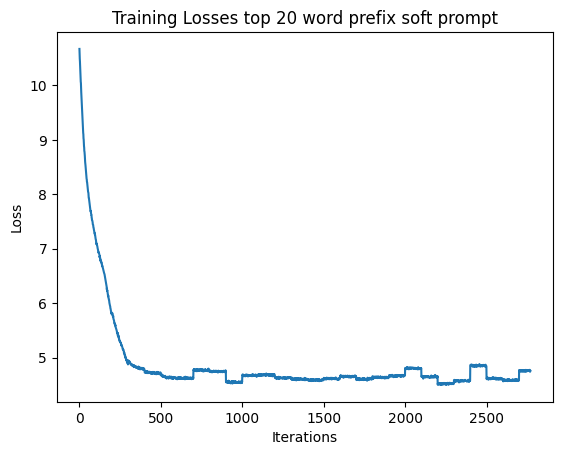

In [ ]:
import matplotlib.pyplot as plt
final_losses = [loss.item() for loss in losses]
# Create a figure and axis object
fig, ax = plt.subplots()

# Create the line plot
ax.plot(final_losses)

# Add a title and axis labels
ax.set_title('Training Losses top 20 word prefix soft prompt')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

# Display the plot
plt.show()

In [ ]:
def top_k_logits(logits, k,topk=0.7):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge

Calculating the rouge score from xsum test dataset

In [ ]:
def get_rouge_score(generated_summary, reference_summary):
  rouge = Rouge()

  # Calculate ROUGE-1, ROUGE-2, and ROUGE-L scores
  scores = rouge.get_scores(generated_summary, reference_summary, avg=True)

  rouge_1_score = scores['rouge-1']['f']
  rouge_2_score = scores['rouge-2']['f']
  rouge_l_score = scores['rouge-l']['f']

  # Print the scores
  #print(f"ROUGE-1 score: {rouge_1_score:.4f}")
  #print(f"ROUGE-2 score: {rouge_2_score:.4f}")
  #print(f"ROUGE-L score: {rouge_l_score:.4f}")
  return [rouge_1_score, rouge_2_score, rouge_l_score]

In [ ]:
import torch.nn.functional as F

In [ ]:
new_test_dataset.set_format("pytorch")



In [ ]:
def generate(examples, temperature, output_length = 120):
  model.eval();
  with torch.no_grad():
    tokens = []
    input_ids = examples['input_ids'].cuda()
    #attention_mask = torch.tensor(examples['attention_mask']).cuda()
    summary_ids = input_ids.clone()
    
    #summary_attention = attention_mask.clone()
    for k in range(output_length):
      logits = model(input_ids=input_ids).logits
      logits = logits[:, -1, :] / temperature
      logits = top_k_logits(logits, 10)
      probs = F.softmax(logits, dim=-1)   
      next_token = torch.multinomial(probs, num_samples=1)
      while next_token == tokenizer.pad_token_id:
          next_token = torch.multinomial(probs, num_samples=1)
      tokens.append(next_token)
      summary_ids = torch.cat([summary_ids, next_token], dim=1)
      input_ids = summary_ids
      #summary_attention = 
      #attention_mask = torch.cat([attention_mask,torch.full((1,1), 1).cuda()],1).cuda()
    #print(summary_ids)
    summary = tokenizer.decode(torch.tensor(tokens), skip_special_tokens=True)
    document = examples['document']
    rouge_score = get_rouge_score(summary, document)
    return {'output_example':summary,'document':document, 'rouge_score':rouge_score}

In [ ]:
temperatures = [0.8]
results = []
for temperature in temperatures:
  results.append(new_test_dataset.map(lambda example:generate(example,temperature,120)))

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
new_test_dataset

Dataset({
    features: ['summary', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 500
})

In [ ]:
# temperatures = [0.5,0.8]
# results = []
# for temperature in temperatures:
#   results.append(new_test_dataset.map(lambda example:generate(example,temperature,120)))

In [ ]:
import pandas as pd
def get_average_rouge_score(scores):
    score_df = pd.DataFrame(scores,columns=['Rouge 1', 'Rouge 2', 'Rouge L'])
    avg = score_df.mean()
    return avg

final rouge score

In [ ]:
get_average_rouge_score(results[0]['rouge_score'])

Rouge 1    0.000498
Rouge 2    0.000000
Rouge L    0.000498
dtype: float32